## Rose Tovar
### RoseATovar@gmail.com
### Heart Failure Prediection Project

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Heart Failure Dataset

In [2]:
heart_df = pd.read_csv('heart.csv')

In [3]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Source
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

### Description
> The dataset looks like different medical asepcts that may infleunce heart failure for isntance RestingBP, Cholesterol, Chest Pain Type, Resting ECG. And list if the individual has had heart Disease

### Target and Type of Problem
> The target being looked at in this problem is Heart Disease making this a classficiation problem

### Number of features and Rows

In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


> We have 12 Columns and 918 Rows

### Checking for Duplicated Data and Removing Unessary Columns

In [5]:
heart_df.duplicated().sum()

0

In [6]:
# No rows are duplicated
# And we do not need to remove any columns

### Checking for missing values

In [7]:
# We have no missing values
heart_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Inconsistencies Check in Categorial Data

In [8]:
# looking at object columns to see if any spelling errors
dtypes = heart_df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols
for col in str_cols:
  print(f"- Column = {col}")
  print(heart_df[col].value_counts(dropna=False))
  print('\n\n')

- Column = Sex
M    725
F    193
Name: Sex, dtype: int64



- Column = ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64



- Column = RestingECG
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64



- Column = ExerciseAngina
N    547
Y    371
Name: ExerciseAngina, dtype: int64



- Column = ST_Slope
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64





In [9]:
# Looking at the cateoorical data we can see there are no Inconsistencies

### Reviewing Data Statistics Initial Look for Out of place data

In [10]:
heart_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [11]:
heart_df.loc[heart_df['Cholesterol'] == 603]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
149,54,M,ASY,130,603,1,Normal,125,Y,1.0,Flat,1


In [12]:
# WE do have an outlier with Cholesterol with it being 603. May need to talk to a subject specialist
# to find out if that is even possible. 

In [13]:
heart_df.loc[heart_df['Oldpeak'] == 6.2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
850,62,F,ASY,160,164,0,LVH,145,N,6.2,Down,1


In [14]:
# 6.2 seems to be a high oldpeak and is an outlier in that column

In [15]:
heart_df.loc[heart_df['RestingBP'] == 0]
# it looks like for this perons they did not get the cholestorol Resting BP or Fasting BS.
# Because of this lack of information i will remove this row


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [16]:
heart_df.drop(449, inplace=True)

heart_df.loc[heart_df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [17]:
heart_df.loc[heart_df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [18]:
# We have a large amount of users with a cholesterol of zero we have we will make that na
# And impute that value with the mean of the column to maintain the average cholesterol

In [19]:
heart_df['Cholesterol'] = heart_df['Cholesterol'].replace(0, np.nan)

heart_df.isna().sum()

# 171 will be used in preprocessing and supply the average cholestorol for those mmissing values

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

### Univariate Visualizations

#### Categorical Count Plots

In [20]:
def createCountPlot(x, df, title):
    fig, ax = plt.subplots(figsize=(12,7))
    sns.countplot(x=x, data=df, ax=ax)
    ax.set_xlabel(title, fontsize=16, labelpad=15)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.set_title(title, fontsize='20')

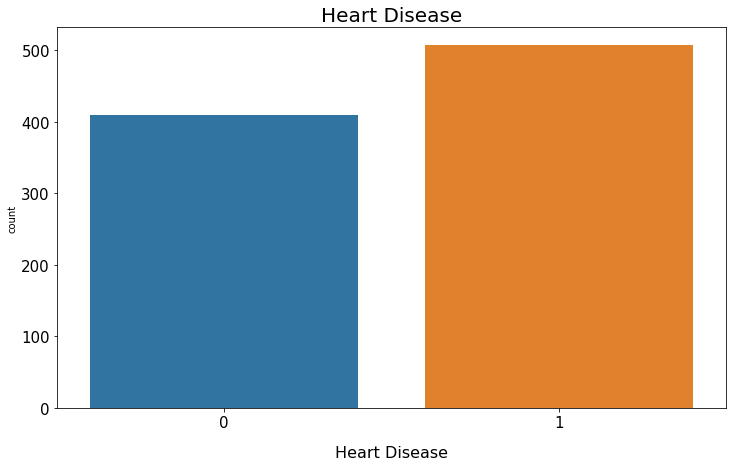

In [21]:
 # The Count of heart disease,
createCountPlot('HeartDisease', heart_df, 'Heart Disease')

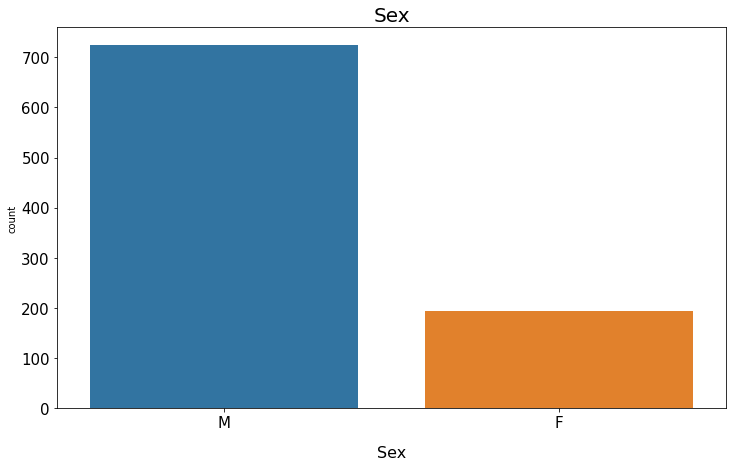

In [22]:
 # The Count of Sex,
createCountPlot('Sex', heart_df, 'Sex')

# There seems to be mostly men in this dataset

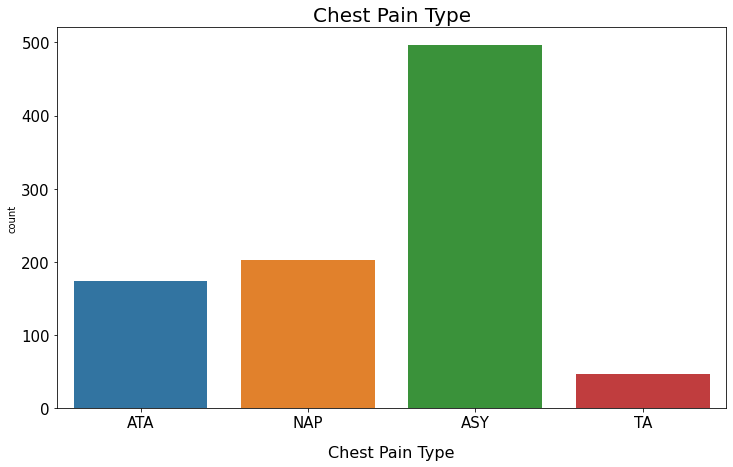

In [23]:
 # The Count of Chest Pain Type,
createCountPlot('ChestPainType', heart_df, 'Chest Pain Type')

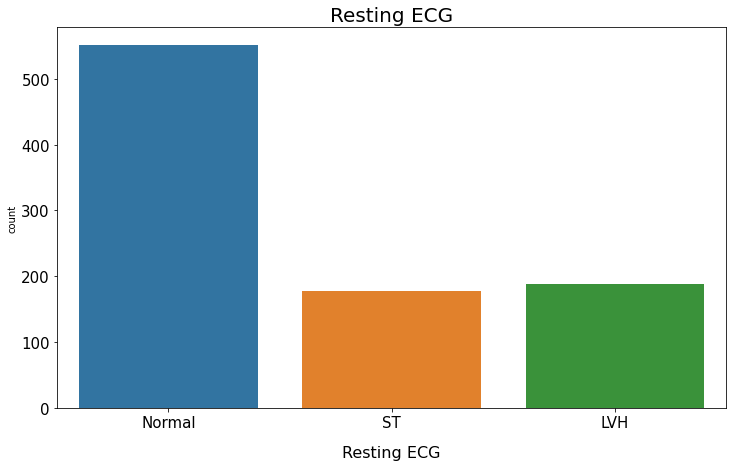

In [24]:
 # The Count of Resting ECG,
createCountPlot('RestingECG', heart_df, 'Resting ECG')

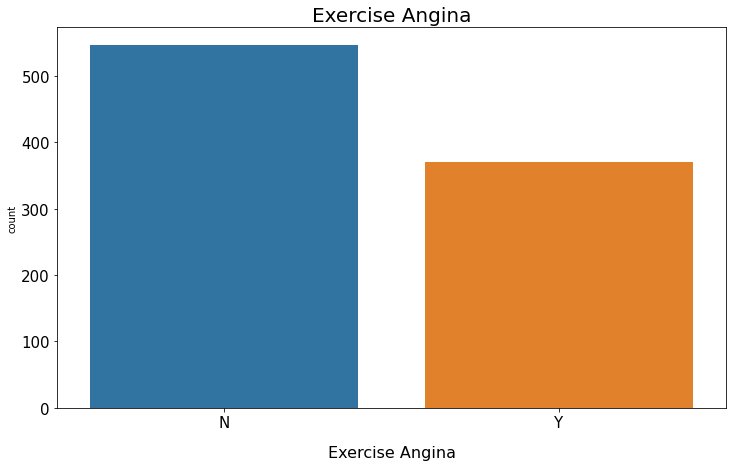

In [25]:
 # The Count of Exercise Angina,
createCountPlot('ExerciseAngina', heart_df, 'Exercise Angina')

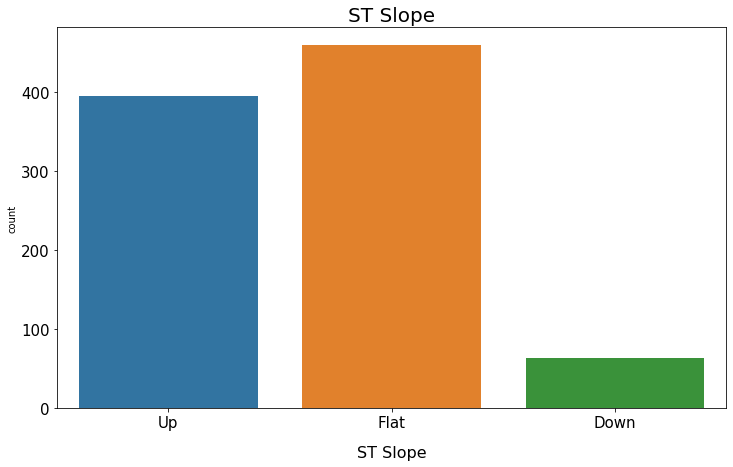

In [26]:
 # The Count of ST Slope,
createCountPlot('ST_Slope', heart_df, 'ST Slope')

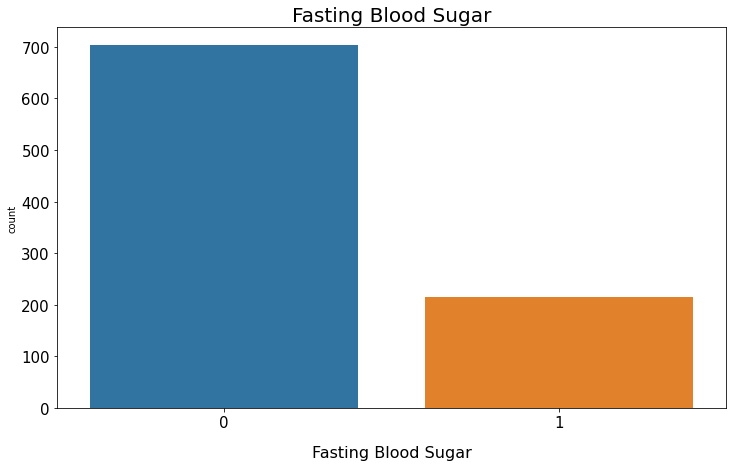

In [27]:
 # The Count of Fasting Blood Sugar,
createCountPlot('FastingBS', heart_df, 'Fasting Blood Sugar')

# Most of the people in this dataset have a resting blood sugar of 0

#### Hist plots for Numerical Columns

In [28]:
def createBoxPlot(x, df, title):
    fig, ax = plt.subplots(figsize=(12,7))
    sns.boxplot(x=x, data=df, ax=ax)
    ax.set_xlabel(f"{x}", fontsize=16, labelpad=15)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.set_title(title, fontsize='20')

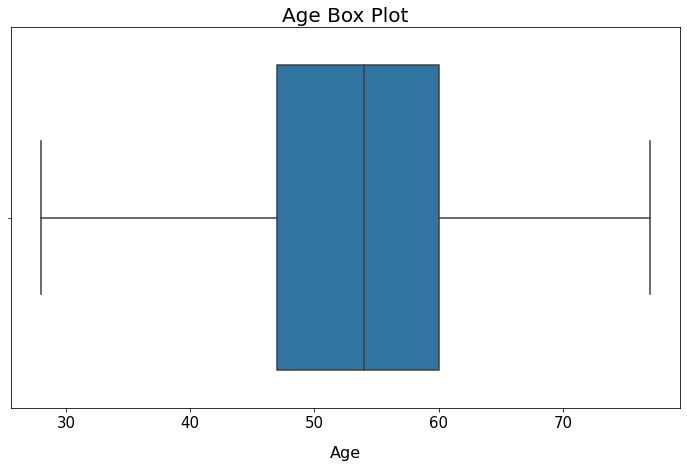

In [29]:
createBoxPlot('Age', heart_df, 'Age Box Plot')

# most individuals in thsi dataset fall between 50 and 70

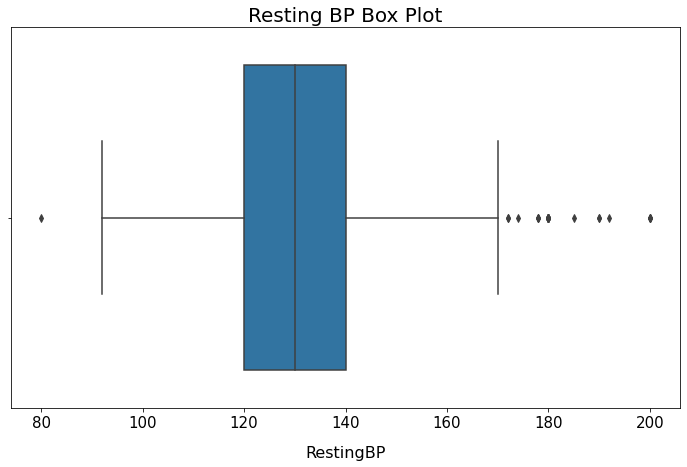

In [30]:
createBoxPlot('RestingBP', heart_df, 'Resting BP Box Plot')

# Looking at this chart we can see that Resting Blood Pressure runs between 80 and 200
# With most of it being between 100 and 280
# Can see that there are 9 outliers in resting blood pressure. 8 of them are above 170, while one goes below 90 

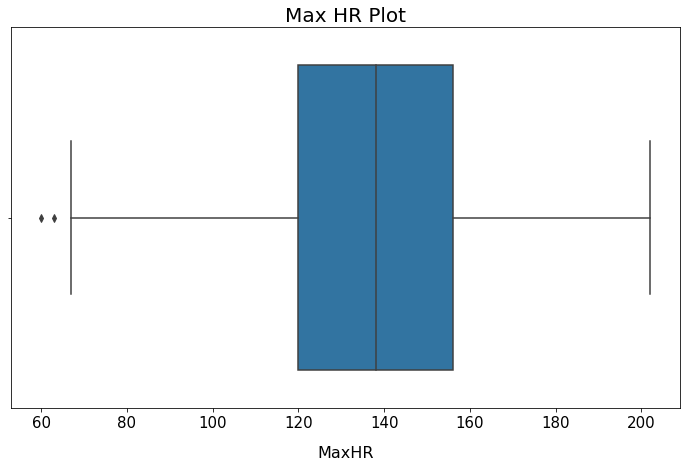

In [31]:
createBoxPlot('MaxHR', heart_df, 'Max HR Plot')
# The heart rates run between 60 to 200 with most being between 120 and 160
# Looking at the Max heart rate we can see that there are 2 outliers with heart rates that go below 70

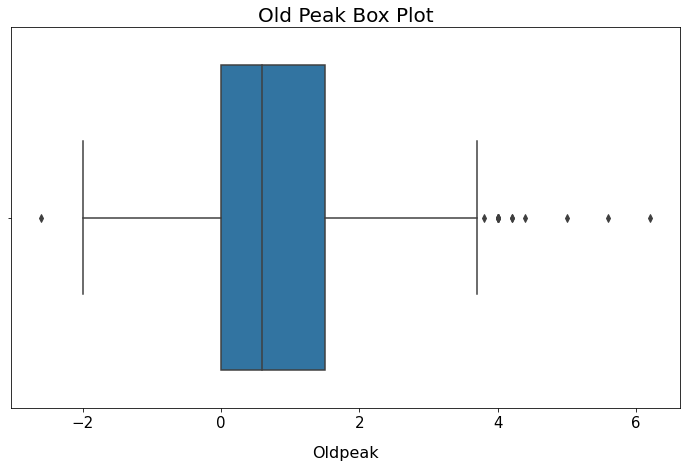

In [32]:
 # The distrubtion of Heart Rates,
createBoxPlot('Oldpeak', heart_df, 'Old Peak Box Plot')

# Most people have an old peak around 0
# We have 8 outliers in Old Peak, 7 of them are just around 4 or above, while one is in -2

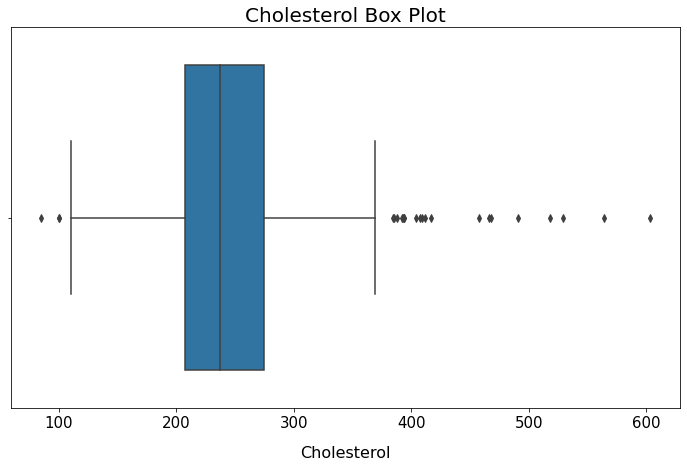

In [33]:
 # The distrubtion of Cholesterols,
createBoxPlot('Cholesterol', heart_df, 'Cholesterol Box Plot')

# not accounting for the nan cholesterols we have about an average of 100 to 400
# We have a lot of outliers in Cholesterol. A good number of rows have a high cholesterol above 370ish
# While two seem to be on the low side around 100